# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Наша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Изучение данных 

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
data = pd.read_csv(r'C:\datasets\real_estate_data.csv', sep='\t')

In [6]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

In [8]:
print('Количсество нулевых значений:')
data.isna().sum()

Количсество нулевых значений:


total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [9]:
print(f'Количество дубликатов: {data.duplicated().sum()}')

Количество дубликатов: 0


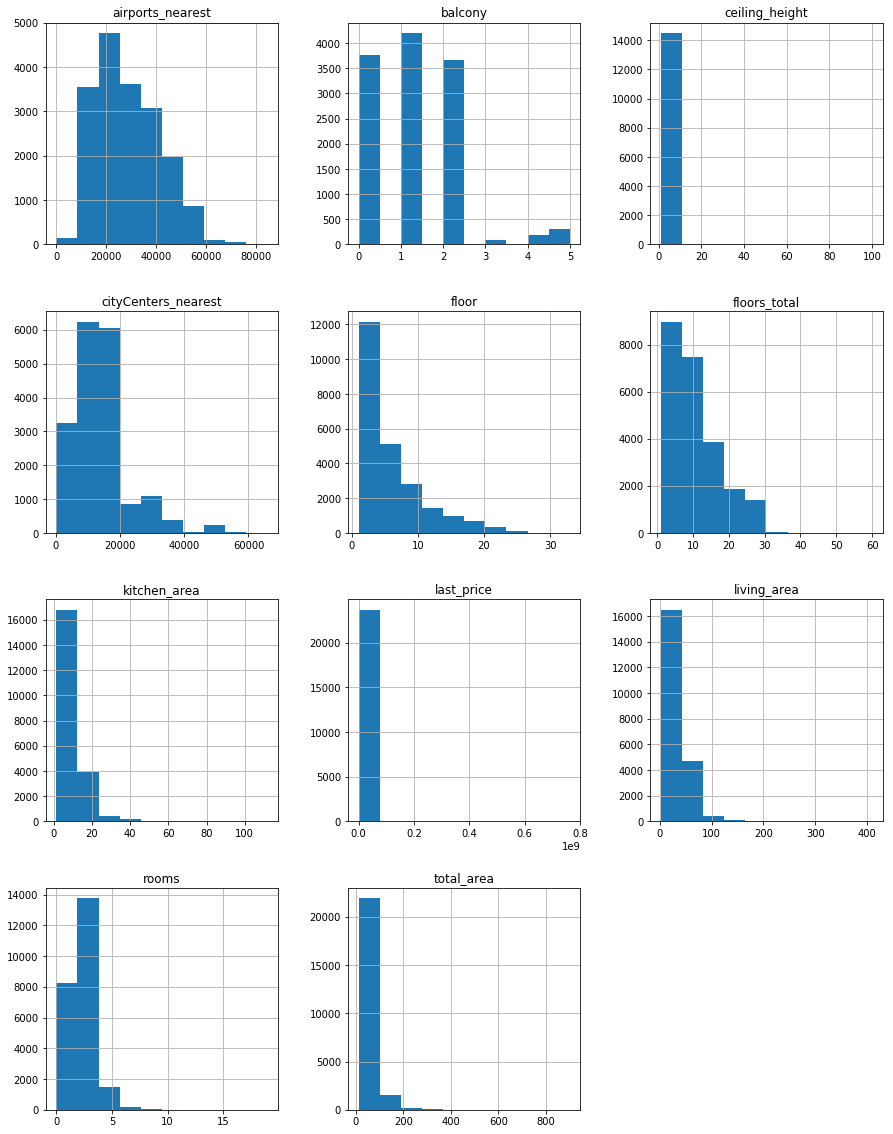

In [18]:
data[['airports_nearest','balcony', 'last_price','total_area', 'rooms', 'ceiling_height',\
     'floors_total', 'living_area', 'floor', 'kitchen_area', 'cityCenters_nearest']]\
    .hist(figsize=(15, 20))
plt.show()

В данных отсутствуют явные дубликаты. А вот пропусков довольно много в некоторых колонках. В том числе и в тех, которые могут влиять на стоимость, такие как жилая площадь, расстояние до центра. Сделать выводы по некоторым графикам тяжело, так как они малоинформативны, их следует изучить подробнее.

## Предобработка данных

### Пропуски в данных

Пропуски в колонке `balcony`. Если количество балконов не указано, скорее всего их нет. Заменим пустые значения на ноль.

In [19]:
data['balcony'].isna().sum()

11519

In [20]:
data.loc[data['balcony'].isna(), 'balcony'] = 0

In [21]:
data['balcony'].isna().sum()

0

Пропуски в колонке `parks_around3000`. Заполним в колонке с количеством парков в радиусе 3 км пустые значения. Если расстояние до парка NaN, то парков в радиусе 3 км нет.

In [22]:
data['parks_around3000'].isna().sum()


5518

In [23]:
data.loc[data['parks_nearest'].isna(), 'parks_around3000'] = 0.0

In [24]:
data['parks_around3000'].isna().sum()

0

Аналогично заполним пропуски в колонке `ponds_around3000`.

In [25]:
data['ponds_around3000'].isna().sum()

5518

In [26]:
data.loc[data['ponds_nearest'].isna(), 'ponds_around3000'] = 0.0

In [27]:
data['ponds_around3000'].isna().sum()

0

Проверим данные в колонке `ceiling_height`.

In [28]:
data.sort_values(by='ceiling_height')['ceiling_height'].unique()

array([  1.  ,   1.2 ,   1.75,   2.  ,   2.2 ,   2.25,   2.3 ,   2.34,
         2.4 ,   2.45,   2.46,   2.47,   2.48,   2.49,   2.5 ,   2.51,
         2.52,   2.53,   2.54,   2.55,   2.56,   2.57,   2.58,   2.59,
         2.6 ,   2.61,   2.62,   2.63,   2.64,   2.65,   2.66,   2.67,
         2.68,   2.69,   2.7 ,   2.71,   2.72,   2.73,   2.74,   2.75,
         2.76,   2.77,   2.78,   2.79,   2.8 ,   2.81,   2.82,   2.83,
         2.84,   2.85,   2.86,   2.87,   2.88,   2.89,   2.9 ,   2.91,
         2.92,   2.93,   2.94,   2.95,   2.96,   2.97,   2.98,   2.99,
         3.  ,   3.01,   3.02,   3.03,   3.04,   3.05,   3.06,   3.07,
         3.08,   3.09,   3.1 ,   3.11,   3.12,   3.13,   3.14,   3.15,
         3.16,   3.17,   3.18,   3.2 ,   3.21,   3.22,   3.23,   3.24,
         3.25,   3.26,   3.27,   3.28,   3.29,   3.3 ,   3.31,   3.32,
         3.33,   3.34,   3.35,   3.36,   3.37,   3.38,   3.39,   3.4 ,
         3.42,   3.43,   3.44,   3.45,   3.46,   3.47,   3.48,   3.49,
      

Видим значения высоты потолка от 20 до 100 м, которые маловероятны. Скорее всего эти значения от 2.0 до 10.0 соответственно. Исправим.

In [29]:
def correct_hight(row):
    if row > 15:
        return (row / 10)
    else:
        return row

data['ceiling_height'] = data['ceiling_height'].apply(correct_hight).round(2)

In [30]:
data.sort_values(by='ceiling_height')['ceiling_height'].unique()

array([ 1.  ,  1.2 ,  1.75,  2.  ,  2.2 ,  2.25,  2.26,  2.3 ,  2.34,
        2.4 ,  2.45,  2.46,  2.47,  2.48,  2.49,  2.5 ,  2.51,  2.52,
        2.53,  2.54,  2.55,  2.56,  2.57,  2.58,  2.59,  2.6 ,  2.61,
        2.62,  2.63,  2.64,  2.65,  2.66,  2.67,  2.68,  2.69,  2.7 ,
        2.71,  2.72,  2.73,  2.74,  2.75,  2.76,  2.77,  2.78,  2.79,
        2.8 ,  2.81,  2.82,  2.83,  2.84,  2.85,  2.86,  2.87,  2.88,
        2.89,  2.9 ,  2.91,  2.92,  2.93,  2.94,  2.95,  2.96,  2.97,
        2.98,  2.99,  3.  ,  3.01,  3.02,  3.03,  3.04,  3.05,  3.06,
        3.07,  3.08,  3.09,  3.1 ,  3.11,  3.12,  3.13,  3.14,  3.15,
        3.16,  3.17,  3.18,  3.2 ,  3.21,  3.22,  3.23,  3.24,  3.25,
        3.26,  3.27,  3.28,  3.29,  3.3 ,  3.31,  3.32,  3.33,  3.34,
        3.35,  3.36,  3.37,  3.38,  3.39,  3.4 ,  3.42,  3.43,  3.44,
        3.45,  3.46,  3.47,  3.48,  3.49,  3.5 ,  3.51,  3.52,  3.53,
        3.54,  3.55,  3.56,  3.57,  3.58,  3.59,  3.6 ,  3.62,  3.63,
        3.65,  3.66,

Видим, что есть потолки более 6 м, а также 1, 1.2. Посмотрим сколько таких строк и удалим их как аномалии.

In [31]:
data.loc[(data['ceiling_height'] > 6) | (data['ceiling_height'] < 1.75)]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3474,3,1400000.0,30.0,2018-03-16T00:00:00,1,8.0,5.0,15.3,2,False,...,7.3,0.0,деревня Нурма,NaN,NaN,0.0,NaN,0.0,NaN,125.0
5712,5,1500000.0,42.8,2017-08-14T00:00:00,2,1.2,2.0,27.5,1,NaN,...,5.2,0.0,городской посёлок Мга,NaN,NaN,0.0,NaN,0.0,NaN,248.0
5863,20,5650000.0,45.0,2018-08-15T00:00:00,1,8.3,16.0,19.3,14,NaN,...,8.3,1.0,Санкт-Петербург,13069.0,10763.0,0.0,NaN,1.0,613.0,14.0
15061,19,5600000.0,56.4,2018-05-11T00:00:00,2,14.0,14.0,32.4,5,NaN,...,9.1,2.0,Санкт-Петербург,14814.0,13610.0,0.0,NaN,0.0,NaN,315.0
15743,14,5600000.0,67.0,2016-11-11T00:00:00,3,8.0,16.0,41.0,1,NaN,...,8.0,0.0,Санкт-Петербург,32691.0,11035.0,1.0,723.0,0.0,NaN,474.0
17442,0,5350000.0,54.0,2015-06-16T00:00:00,2,8.0,5.0,29.0,2,NaN,...,NaN,1.0,Красное Село,24638.0,28062.0,0.0,NaN,0.0,NaN,469.0
22309,20,5300000.0,45.0,2017-09-30T00:00:00,1,10.3,16.0,15.5,15,NaN,...,NaN,0.0,Санкт-Петербург,36353.0,11936.0,2.0,440.0,2.0,450.0,136.0
22590,16,6000000.0,55.0,2018-10-31T00:00:00,2,1.0,12.0,32.4,7,NaN,...,10.0,0.0,Санкт-Петербург,33053.0,14217.0,2.0,293.0,2.0,289.0,13.0
22869,0,15000000.0,25.0,2018-07-25T00:00:00,1,10.0,5.0,14.0,5,True,...,11.0,5.0,Санкт-Петербург,34963.0,8283.0,1.0,223.0,3.0,30.0,19.0


In [32]:
data = data.drop(data.loc[(data['ceiling_height'] > 6) | (data['ceiling_height'] < 1.75)].index)
data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,...,25.00,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,...,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,...,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,...,41.00,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,...,9.10,0.0,городской посёлок Янино-1,NaN,NaN,0.0,NaN,0.0,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,...,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,...,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,...,8.81,0.0,посёлок Мурино,NaN,NaN,0.0,NaN,0.0,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,...,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


In [33]:
data['ceiling_height'].isna().sum()

9195

Заменим пустые значения высоты потолка медианным.

In [34]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())
data['ceiling_height'].isna().sum()

0

Заполним пустые значения в колонке `is_apartment`. Если не указано апартаменты это или нет, то скорее всего имелось ввиду, что нет.

In [35]:
data['is_apartment'].unique()

array([nan, False, True], dtype=object)

In [36]:
data['is_apartment'] = data['is_apartment'].fillna(value=False)

data['is_apartment'].unique()

array([False,  True])

Заполним пропуски в колонке `living_area`.

In [37]:
data['living_area'].isna().sum()

1903

Посчитаем какую часть жилая площадь занимает от общей. Заменим медианным значением.

In [38]:
living = data['living_area'].median() / data['total_area'].median()
data['living_area'] = data['living_area'].fillna(living * data['total_area'])
data['living_area'].isna().sum()

0

Аналогично заполним пустые значения в колонке `kitchen_area`.

In [39]:
kitchen = data['kitchen_area'].median() / (data['total_area'] - data['living_area']).median()
data['kitchen_area'] = data['kitchen_area'].fillna(kitchen * (data['total_area']- data['living_area']))
data['kitchen_area'].isna().sum()

0

Проверим, что площадь кухни и жилая площадь в сумме не превышает общую площадь.

In [40]:
data.loc[(data['kitchen_area'] + data['living_area']) > data['total_area'], ['kitchen_area', 'living_area', 'total_area']]

,kitchen_area,living_area,total_area
184,6.20,26.100000,30.20
545,5.00,20.000000,23.80
551,9.28,30.550000,31.59
601,7.00,48.300000,53.70
696,23.43,23.430000,34.69
1060,20.50,39.000000,50.00
1155,12.00,33.000000,38.00
1354,19.00,38.000000,54.50
1407,18.20,18.000000,24.60
1854,14.84,55.000000,60.20


Видим, что такие строки есть(76 штук), удалим их как аномалии.

In [41]:
data = data.drop(data.loc[(data['kitchen_area'] + data['living_area']) > data['total_area']].index)
data.loc[(data['kitchen_area'] + data['living_area']) > data['total_area'], ['kitchen_area', 'living_area', 'total_area']].sum()

kitchen_area    0.0
living_area     0.0
total_area      0.0
dtype: float64

### Возможные причины пропусков.

* В колонках с количеством парков и водоемов в радиусе 3 км, а также с количеством балконов, отсутствие значений может быть связано с отсутствие наличия парков, водоемов и балконов. 
* В колонке `is_apartment` если квартира не была апартаментами могли ничего и не указывать.
* В остальных колонках не заполнили значение. 

### Типы данных

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23614 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23614 non-null int64
last_price              23614 non-null float64
total_area              23614 non-null float64
first_day_exposition    23614 non-null object
rooms                   23614 non-null int64
ceiling_height          23614 non-null float64
floors_total            23528 non-null float64
living_area             23614 non-null float64
floor                   23614 non-null int64
is_apartment            23614 non-null bool
studio                  23614 non-null bool
open_plan               23614 non-null bool
kitchen_area            23614 non-null float64
balcony                 23614 non-null float64
locality_name           23565 non-null object
airports_nearest        18098 non-null float64
cityCenters_nearest     18121 non-null float64
parks_around3000        23614 non-null float64
parks_nearest           8052 non-null float64
ponds_around3000

Переведем данные столбца с датой объявления в формат даты и округлим до дня публикации.

In [43]:
data['first_day_exposition'].unique()

array(['2019-03-07T00:00:00', '2018-12-04T00:00:00',
       '2015-08-20T00:00:00', ..., '2014-12-29T00:00:00',
       '2016-09-12T00:00:00', '2015-07-19T00:00:00'], dtype=object)

In [44]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%d %H:%M:%S')
data['first_day_exposition'] = data['first_day_exposition'].dt.round('1D')
data['first_day_exposition']

0       2019-03-07
1       2018-12-04
2       2015-08-20
3       2015-07-24
4       2018-06-19
5       2018-09-10
6       2017-11-02
7       2019-04-18
8       2018-05-23
9       2017-02-26
10      2017-11-16
11      2018-08-27
12      2016-06-30
13      2017-07-01
14      2016-06-23
15      2017-11-18
16      2017-11-23
17      2016-09-09
18      2017-01-27
19      2019-01-09
20      2017-09-28
21      2018-03-14
22      2017-04-24
23      2016-10-29
24      2015-10-31
25      2015-10-01
26      2017-04-28
27      2017-05-12
28      2017-12-13
29      2016-04-09
           ...    
23669   2017-11-10
23670   2018-02-08
23671   2017-04-14
23672   2016-06-08
23673   2018-03-19
23674   2019-03-05
23675   2016-10-03
23676   2016-06-08
23677   2018-10-26
23678   2016-05-19
23679   2017-12-08
23680   2019-04-04
23681   2018-05-11
23682   2016-06-23
23683   2018-09-18
23684   2018-11-02
23685   2019-01-24
23686   2017-04-29
23687   2017-12-16
23688   2019-04-01
23689   2018-02-28
23690   2018

Переведем в целые числа цену, количество балконов, парков и водоемов.

In [45]:
data['last_price'] = data['last_price'].apply(lambda row: int(row))
data['last_price'].unique()

array([13000000,  3350000,  5196000, ...,  6151120, 21400000, 11475000],
      dtype=int64)

In [46]:
data['balcony'] = data['balcony'].apply(lambda row: int(row))
data['balcony'].unique()

array([0, 2, 1, 5, 4, 3], dtype=int64)

In [47]:
data['parks_around3000'] = data['parks_around3000'].apply(lambda row: int(row))
data['parks_around3000'].unique()

array([1, 0, 2, 3], dtype=int64)

In [48]:
data['ponds_around3000'] = data['ponds_around3000'].apply(lambda row: int(row))
data['ponds_around3000'].unique()

array([2, 0, 3, 1], dtype=int64)

### Уникальные значения в названиях населенных пунктов.

In [49]:
data.sort_values(by='locality_name')['locality_name'].unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

Есть неявные дубликаты в названиях. Например, "поселок" и "посёлок", "посёлок при железнодорожной станции" и "посёлок станции", "городской посёлок" и "посёлок городского типа" это одно и тоже. Исправим.

In [50]:
def replace_name(row):
    try:
        if 'поселок' in row:
            return row.replace('поселок', 'посёлок')
        elif 'посёлок при железнодорожной станции' in row:
            return row.replace('посёлок при железнодорожной станции', 'посёлок станции')
        elif 'городской посёлок' in row:
            return row.replace('городской посёлок', 'посёлок городского типа')     
        elif 'коттеджный посёлок' in row:
            return row.replace('коттеджный посёлок', 'посёлок')
        else:
            return row
    except:
        return row

data['locality_name'] = data['locality_name'].apply(replace_name)
data['locality_name'].value_counts()

Санкт-Петербург                       15669
посёлок Мурино                          552
посёлок Шушары                          438
Всеволожск                              395
Пушкин                                  369
Колпино                                 337
посёлок Парголово                       326
Гатчина                                 303
деревня Кудрово                         299
Выборг                                  236
Петергоф                                200
Сестрорецк                              182
Красное Село                            177
Кудрово                                 173
деревня Новое Девяткино                 144
Сертолово                               142
Ломоносов                               133
Кириши                                  125
посёлок Бугры                           114
Сланцы                                  112
Волхов                                  111
Тосно                                   104
Кингисепп                       

### Аномалии

У нас были аномалии в колонке с высотой потолков. Некоторые значения написали с ошибкой(не там поставили разделитель), также было значение, которое написали не в тот столбец(скорее всего 14 означал этаж, а не высоту потолка).
При заполнении пустых значений в площади, в некоторых строках получилось так, что сумма площади кухни и жилой площади больше общей. Такого быть не может, поэтому мы удалили эти строки.

## Добавление новых столбцов

**Цена одного квадратного метра.**

In [51]:
data['price_square_m'] = (data['last_price'] / data['total_area']).round(2)
data['price_square_m']

0        120370.37
1         82920.79
2         92785.71
3        408176.10
4        100000.00
5         95065.79
6         99195.71
7        110544.69
8         87454.76
9         88524.59
10       127525.25
11        75000.00
12        72037.04
13        82943.93
14       122222.22
15       119230.77
16        81707.32
17       116111.11
18       104838.71
19       117355.37
20        76500.00
21       101265.82
22        86206.90
23        92187.50
24        66872.43
25        89473.68
26        67500.00
27       101428.57
28        94772.73
29        86000.00
           ...    
23669     87976.54
23670     53728.07
23671     97733.71
23672     97402.60
23673    134782.61
23674    106250.00
23675     89873.42
23676     97527.47
23677     70000.00
23678     81395.35
23679     71428.57
23680     84745.76
23681    122093.02
23682     66011.24
23683     33439.49
23684    147586.21
23685     80322.58
23686    106451.61
23687     82051.28
23688     91089.11
23689    100566.57
23690    105

**День, месяц и год публикации.**

In [52]:
data['weekday'] = data['first_day_exposition'].dt.weekday
data['weekday']

0        3
1        1
2        3
3        4
4        1
5        0
6        3
7        3
8        2
9        6
10       3
11       0
12       3
13       5
14       3
15       5
16       3
17       4
18       4
19       2
20       3
21       2
22       0
23       5
24       5
25       3
26       4
27       4
28       2
29       5
        ..
23669    4
23670    3
23671    4
23672    2
23673    0
23674    1
23675    0
23676    2
23677    4
23678    3
23679    4
23680    3
23681    4
23682    3
23683    1
23684    4
23685    3
23686    5
23687    5
23688    0
23689    2
23690    3
23691    3
23692    4
23693    4
23694    1
23695    0
23696    6
23697    1
23698    4
Name: weekday, Length: 23614, dtype: int64

In [53]:
data['month_of_publication'] = data['first_day_exposition'].dt.month
data['month_of_publication']

0         3
1        12
2         8
3         7
4         6
5         9
6        11
7         4
8         5
9         2
10       11
11        8
12        6
13        7
14        6
15       11
16       11
17        9
18        1
19        1
20        9
21        3
22        4
23       10
24       10
25       10
26        4
27        5
28       12
29        4
         ..
23669    11
23670     2
23671     4
23672     6
23673     3
23674     3
23675    10
23676     6
23677    10
23678     5
23679    12
23680     4
23681     5
23682     6
23683     9
23684    11
23685     1
23686     4
23687    12
23688     4
23689     2
23690     7
23691    10
23692     7
23693     8
23694     3
23695     1
23696     2
23697     3
23698     7
Name: month_of_publication, Length: 23614, dtype: int64

In [54]:
data['year_of_publication'] = data['first_day_exposition'].dt.year
data['year_of_publication']

0        2019
1        2018
2        2015
3        2015
4        2018
5        2018
6        2017
7        2019
8        2018
9        2017
10       2017
11       2018
12       2016
13       2017
14       2016
15       2017
16       2017
17       2016
18       2017
19       2019
20       2017
21       2018
22       2017
23       2016
24       2015
25       2015
26       2017
27       2017
28       2017
29       2016
         ... 
23669    2017
23670    2018
23671    2017
23672    2016
23673    2018
23674    2019
23675    2016
23676    2016
23677    2018
23678    2016
23679    2017
23680    2019
23681    2018
23682    2016
23683    2018
23684    2018
23685    2019
23686    2017
23687    2017
23688    2019
23689    2018
23690    2018
23691    2016
23692    2017
23693    2016
23694    2017
23695    2018
23696    2018
23697    2017
23698    2017
Name: year_of_publication, Length: 23614, dtype: int64

**Тип этажа квартиры.**

In [55]:
type_floor = []
for i in range(len(data['floor'])):
    try:
        if data['floor'][i] == 1:
            type_floor.append('первый')
        elif data['floor'][i] == data['floors_total'][i]:
            type_floor.append('последний')
        else:
            type_floor.append('другие')
    except:
        type_floor.append(None)
data['type_floor'] = type_floor
data[['type_floor', 'floor','floors_total']][15:25]

,type_floor,floor,floors_total
15,другие,5,14.0
16,первый,1,5.0
17,другие,7,17.0
18,другие,2,5.0
19,другие,8,16.0
20,другие,11,27.0
21,другие,2,5.0
22,другие,15,25.0
23,последний,9,9.0
24,первый,1,3.0


**Расстояние до центра города в км.**

In [56]:
import math
def to_km(row):
    try:
        return round(row / 1000)
    except:
        return row

data['cityCenter_km'] = data['cityCenters_nearest'].apply(to_km)
data['cityCenter_km']

0        16.0
1        19.0
2        14.0
3         7.0
4         8.0
5         NaN
6        19.0
7        12.0
8         NaN
9        15.0
10       14.0
11       52.0
12        NaN
13       33.0
14       31.0
15       14.0
16       11.0
17       15.0
18       11.0
19       13.0
20       19.0
21       10.0
22        NaN
23       14.0
24        2.0
25       15.0
26       11.0
27       11.0
28       31.0
29       12.0
         ... 
23669    30.0
23670     NaN
23671    15.0
23672    14.0
23673    12.0
23674     9.0
23675    15.0
23676    12.0
23677     NaN
23678    28.0
23679     NaN
23680    12.0
23681     7.0
23682     NaN
23683     NaN
23684    11.0
23685    52.0
23686    12.0
23687    17.0
23688    14.0
23689    16.0
23690     6.0
23691     4.0
23692     NaN
23693    34.0
23694     4.0
23695     NaN
23696     NaN
23697    10.0
23698     NaN
Name: cityCenter_km, Length: 23614, dtype: float64

## Проведем исследовательский анализ данных

### Построим гистограммы для некоторых колонок

**Общая площадь, жилая площадь, площадь кухни.**

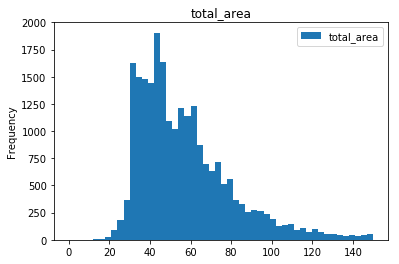

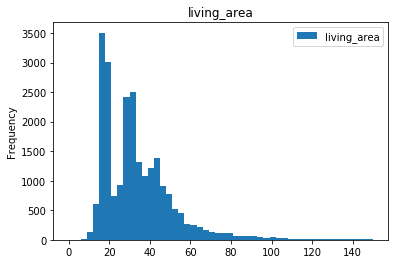

In [57]:
rows = ['total_area', 'living_area']

for row in data[rows]:
    data.plot(kind='hist', y=row, title=row, range=(0, 150), bins=50)

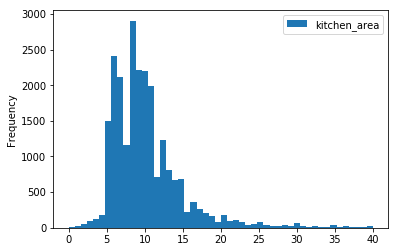

In [58]:
data.plot(kind='hist', y='kitchen_area', range=(0, 40), bins=50)

Из графиков видно, что чаще всего встречаются квартиры с общей площадью 50 $м^2$, жилой площадью 18 $м^2$, площадью кухни 6 $м^2$.

**Цена объекта.**

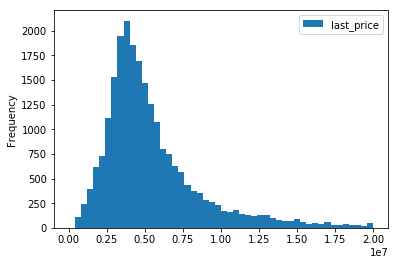

In [59]:
data.plot(kind='hist', y='last_price', range=(0, 20_000_000), bins=50)

Видно, что более 2 000 объявлений со стоимостью квартир 4,5 млн.

**Количество комнат.**

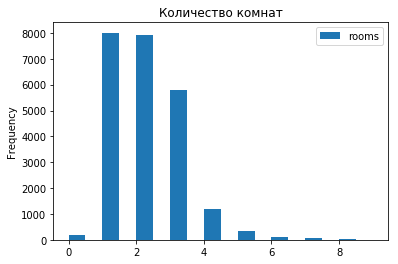

In [60]:
data.plot(kind='hist', y='rooms', title='Количество комнат', range=(0, 9), bins=18)

Больше всего в датасете однокомнатных квартир, чуть меньше двухкомнатных.

**Высота потолков.**

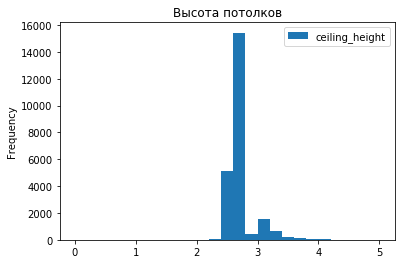

In [61]:
data.plot(kind='hist', y='ceiling_height', title='Высота потолков', range=(0, 5), bins=25)

Самая распространенная высота потолка 2.6

**Этаж квартиры и всего этажей в здании.**

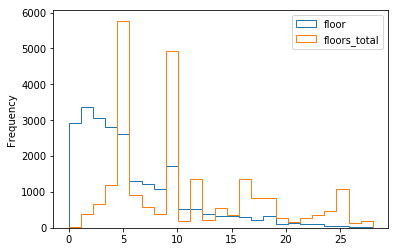

In [62]:
ax = data.plot(kind='hist', y='floor', histtype='step', range=(0, 28), bins=25)
data.plot(kind='hist', y='floors_total', histtype='step', range=(0, 28), bins=25, ax=ax, legend=True)

Из графика видно, что больше всего квартир находятся на первых пяти этажах. Чаще всего встречаются квартиры в пятиэтажных домах, чуть меньше объявлений о продаже квартир в девятиэтажках. 

**Тип этажа квартиры.**

<BarContainer object of 3 artists>

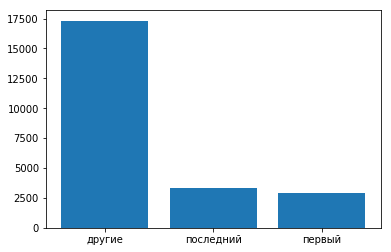

In [63]:
type_floor_count = data['type_floor'].value_counts()
plt.bar(type_floor_count.index, type_floor_count.values)

Логично, что категория этажей "другие" наибольшая. Квартир на последнем этаже не намного больше чем на первом. 

**Расстояние до центра города, парка, аэропорта в метрах.**

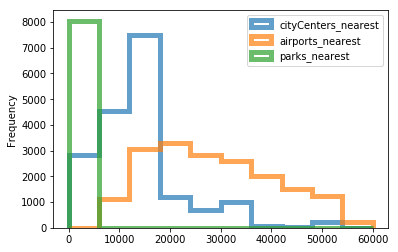

In [64]:
areas = ['cityCenters_nearest', 'airports_nearest', 'parks_nearest']
data.plot(kind='hist', y=areas, alpha=0.7, histtype='step', linewidth=5, range=(0, 60_000))

Данные о расстоянии до ближайшего парка у нас есть, в основном, только до 3 км. Видим, что большинство квартир находятся на расстоянии 15 км от центра. До аэропорта расстояние варьируется от 12 до 55 км.

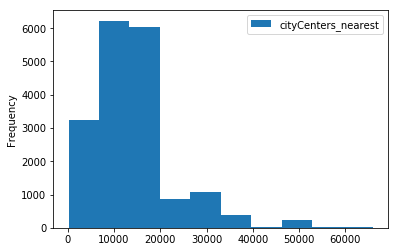

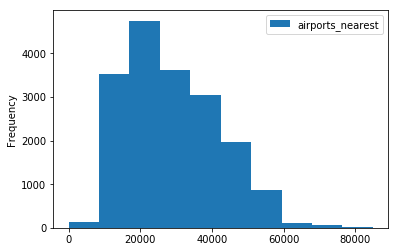

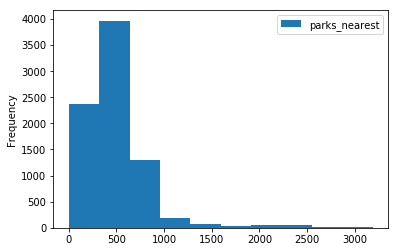

In [65]:
areas = ['cityCenters_nearest', 'airports_nearest', 'parks_nearest']

for area in data[areas]:
    data.plot(kind='hist', y=area, alpha=1)

**День и месяц публикации объявления.**

In [66]:
data['day_of_publication'] = data['first_day_exposition'].dt.day
data['day_of_publication'].value_counts()[:10]

1     1136
10    1100
26     889
12     867
20     864
11     834
14     833
13     823
15     820
21     820
Name: day_of_publication, dtype: int64

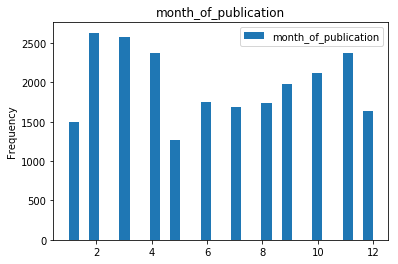

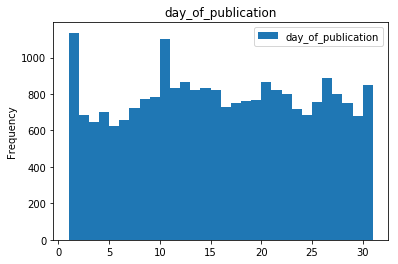

In [67]:
dates = ['month_of_publication', 'day_of_publication']
for date in data[dates]:
    data.plot(y=date, kind='hist', title=date, bins=30)

Text(0.5,1,'Дата публикации')

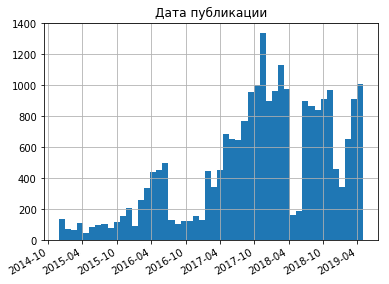

In [69]:
data['first_day_exposition'].hist(bins=50)
plt.xticks(rotation=30, ha='right')
plt.title('Дата публикации')

Чаще всего публикуют объявления 1 числа и 10. Также в феврале и марте было опубликовано больше всего объявлений. Пик пришелся на февраль 2018 года.

### Проанализируем `days_exposition`.

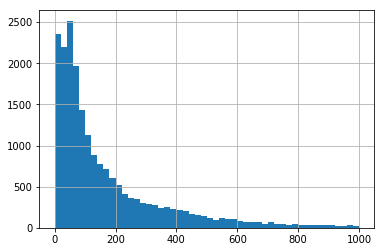

In [70]:
data['days_exposition'].hist(range=(0, 1000), bins=50)

In [72]:
print('Среднее значение', round(data['days_exposition'].mean(),2))
print('Медиана', data['days_exposition'].median())

Среднее значение 180.98
Медиана 95.0


Половина всех объявлений находится на сайте до 95 дней. Это можно считать довольно быстрой продажей. В среднем квартира продается пол года. Но есть значения и в год, и в полтора, и даже в два. Можно сказать, что продажа квартиры в течении более чем полутора лет считается долгой.

### Факторы, влияющие на стоимость

Построим heatmap для колонок `total_area`, `living_area`, `kitchen_area`, `rooms`, `type_floor`, `last_price`. Это тепловая карта покажет нам значение коэффициента Пирсона. Этот коэффициент поможет определить наличие линейной связи между величинами. Чем ближе коэффициент к 1 или -1, тем теснее связь.

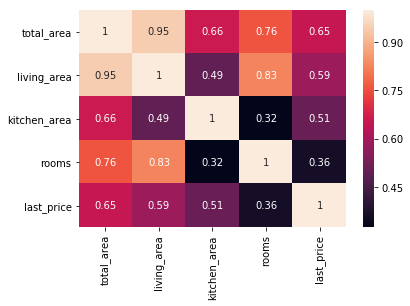

In [73]:
columns = ['total_area', 'living_area', 'kitchen_area', 'rooms', 'type_floor', 'last_price']
hm = sns.heatmap(data[columns].corr(),annot=True)

Видим, что на стоимость квартиры сильнее всего влияет общая площадь. А жилая площадь и площадь кухни связаны с общей, и они влияют меньше, но, естественно, связь есть. Комнаты практически не влияют.

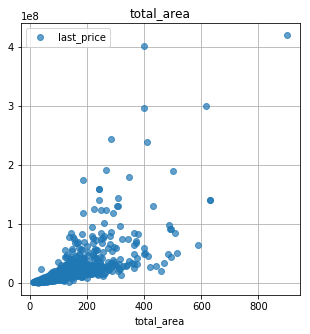

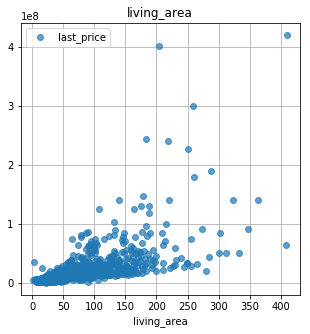

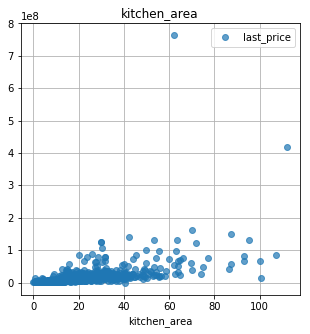

In [74]:
columns1 = ['total_area', 'living_area', 'kitchen_area']
for column in columns1:
    data.pivot_table(index=column, values='last_price').plot(grid=True, title=column, style='o', alpha=0.7, figsize=(5, 5))

На графике с общей площадью лучше всего просматривается линейная зависимость. На графике с площадью кухни, прямая располагалась бы ближе к оси х, то есть под углом около 30 градусов.

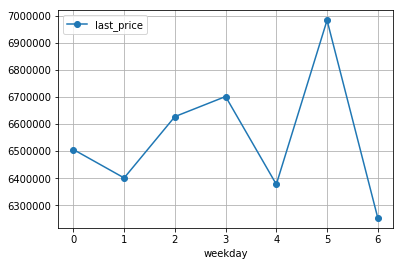

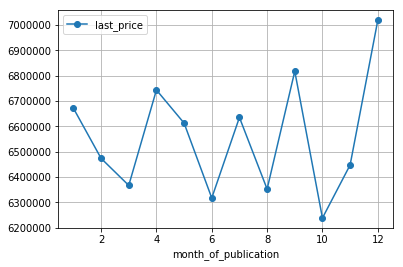

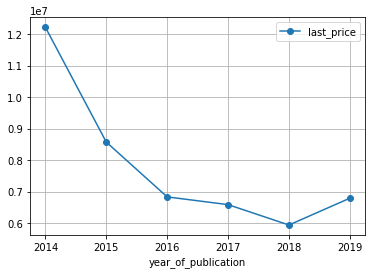

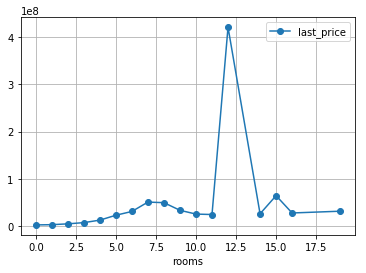

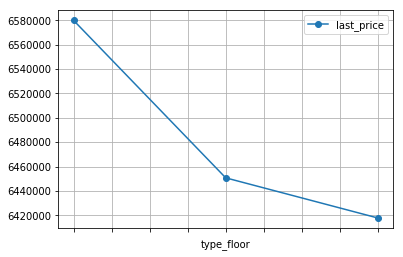

In [75]:
columns2 = ['weekday', 'month_of_publication', 'year_of_publication', 'rooms', 'type_floor']
for column2 in columns2:
    data.pivot_table(index=column2, values='last_price').plot(style='o-', grid=True)

* Из графиков видно, что чаще всего объявления о продаже выставляют в субботу. * Также большинство объявлений выставлено в декабре, но небольшой пик был и осенью. 
* В 2014 году рост количества продаж квартир, с каждым годом количество продающих падало.
* Видно, что чем больше комнат, тем выше цена. На графике пик на объявлении с 12 комнатами. Посмотрим это объявление.
* В продажах меньше всего квартир на последних этажах, и больше всего на "других".

In [76]:
data.loc[data['rooms'] == 12]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_square_m,weekday,month_of_publication,year_of_publication,type_floor,cityCenter_km,day_of_publication
19540,8,420000000,900.0,2017-12-06,12,2.8,25.0,409.7,25,False,...,2,318.0,106.0,466666.67,2,12,2017,другие,8.0,6


Стоимость квартиры 420 млн, а площадь 900 $м^2$. Мы выяснили, что цена зависит от площади квартиры, также, как и количество комнат(то есть, не так важно сколько в квартире перегородок, важнее ее общая площадь).

## Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделим населённые пункты с самой высокой и низкой стоимостью квадратного метра.

In [77]:
top_name = data['locality_name'].value_counts()[:10]

In [78]:
price_top_name = data[['price_square_m', 'locality_name']].where(data['locality_name'].isin(top_name.index))

In [79]:
price_top_name.dropna(inplace=True)

In [80]:
mean_price_top_name = price_top_name.groupby('locality_name')['price_square_m'].mean().round(2)

<BarContainer object of 10 artists>

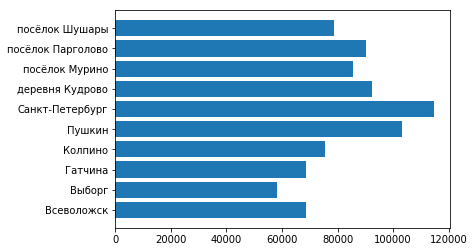

In [81]:
plt.barh(mean_price_top_name.index, mean_price_top_name.values)

In [82]:
print(f'В Санкт-Петербурге самая высокая стоимость одного квадратного метра: {mean_price_top_name.max()}')
print(f'В Выборге самая низкая стоимость одного квадратного метра: {mean_price_top_name.min()}')

В Санкт-Петербурге самая высокая стоимость одного квадратного метра: 114736.65
В Выборге самая низкая стоимость одного квадратного метра: 58154.34


## Выделим квартиры в Санкт-Петербурге и вычислим среднюю цену каждого километра. Опишем, как стоимость объектов зависит от расстояния до центра города.

Напишем функцию для нахождения цены за км.

In [83]:
def price_km(df):
    try:
        return int(df['last_price']/df['cityCenter_km'])
    except:
        return None

data['price_km'] = data.apply(price_km, axis=1)

Выберем строки, где город Санкт-Петербург.

In [84]:
spb = data.query('locality_name == "Санкт-Петербург"')

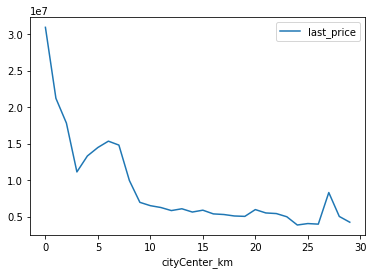

In [85]:
(
spb
    .pivot_table(index='cityCenter_km', values='last_price')
    .plot(kind='line')
)

## Общий вывод

Проанализировав данные, мы пришли к выводу, что:
* Чаще всего встречается двухкомнатная квартира, с общей площадью 50 $м^2$, жилой - 18 $м^2$, кухни - 6 $м^2$, с высотой потолка 2.6 м,  не на первом и не на последнем этаже, с ценой около 4,5 млн.
* Больше всего объявлений о продаже в домах с пятью или девятью этажами.
* Чаще всего публикуют объявления в конце зимы, начале весны, в первых числах месяца.
* В среднем квартиры продаются в течении полугода. Но половина всех объявлений о продаже находятся на сайте три месяца.
* Фактором, влияющим на стоимость квартиры является общая площадь.
* Средняя цена за квадратный метр зависит от населенного пункта. Например, в Санкт-Петербурге он максимален и равен 114736 руб, а в Выборге самая низкая стоимость - 58154 руб.
* На последнем графике видно, что чем ближе к центру находится квартира, тем больше разброс цен на нее, чем дальше - тем меньше разброс и ниже цена за квадратный км.